# Gravitational Wave Data Analysis:
---

## Part A: Data Acquisition
In this part of the notebook we will use the gravitational wave data analysis toolkit called `PyCBC` to download, read and process real gravitational wave data. By the end we should be able to identify few real gravitational wave events by their event times.

In order to reach this goal we will need to learn how to handle data from the LIGO and Virgo observatories, including how to do the necessary data conditioning and matched filtering.
Further, more technical reading on this topic can be found in [Abbott et al. (2020)](https://dx.doi.org/10.1088/1361-6382/ab685e)[[arXiv:1908.11170]](https://arxiv.org/abs/1908.11170).

This tutorial is inspired from Andrew Williamson's notebooks from the 2021 Nikhef GW workshop based on the [Gravitational Wave Open Data Workshop](https://github.com/gw-odw) and [`PyCBC` Tutorials](https://github.com/gwastro/PyCBC-Tutorials) repositories, taking code and inspiration heavily from both.

If you're interested in learning more about GW signal detection and pre-processing, I recommend looking at the aforementioned resources for other extensive examples.

---

### 0. Install required software
- In this particular notebook, we will use `PyCBC`. Let us go ahead and install `PyCBC` and all its dependencies including `lalsuite` and `ligo-common`.
- You can do this (once) in your local machine with a working Python (3.7 and higher) installation or in a remote server using google colab.
- Ideally, use a virtual environment (`python venv` or `conda`) to install all necessary packages if you're using your local machine.

In [1]:
NEED_TO_INSTALL_PACKAGES = True
if NEED_TO_INSTALL_PACKAGES:
    ## Check if pip matches your desired python installation/environment
    ! which pip
    ## Install pycbc and dependencies
    ! pip install pycbc lalsuite ligo-common

## Import packages
import matplotlib.pyplot as plt
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
import numpy as np
import pycbc

/usr/local/bin/pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 kB 1.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 29.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 2.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 100.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.6 MB/s eta 0:00:

/usr/local/lib/python3.11/dist-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


---

### 1. Download data from the Gravitational Wave Open Science Center (GWOSC)
- The Gravitational Wave Open Science Center (GWOSC – [gw-openscience.org](https://www.gw-openscience.org)) contains public resources and data from the gravitational wave detectors.

- Not all data is immediately made public but the data surrounding the time of all published detection candidates is made public at time of publication. Later, after a proprietory period, the data from entire observing runs are made available.

Let us download some data surrounding our first ever GW detection GW150914.


In [2]:
from pycbc import catalog

# Retreive an event's information (including data)
event_name = "GW190412" # https://gwosc.org/eventapi/html/GWTC-1-confident/GW170814/v3/
catalog_name = "gwtc-2" # refers to the first published GW transient catalog

merger = catalog.Merger(
                        name=event_name,
                        source=catalog_name
                        )
## A good idea to check what attributes the merger object contains
print(f"GW event {merger.common_name} occured at GPS time {merger.time}.\n"
      f"It has binary component masses mass_1 = {merger.mass1}, and mass_2 = {merger.mass2}.\n"
      f"The merger event was {merger.distance} Mpc away (redshift = {merger.redshift}).\n"
      )
## The merger object also contains the data of the event

GW event GW190412 occured at GPS time 1239082262.2.
It has binary component masses mass_1 = 30.1, and mass_2 = 8.3.
The merger event was 740.0 Mpc away (redshift = 0.15).



Let us visualise the raw data of the merger

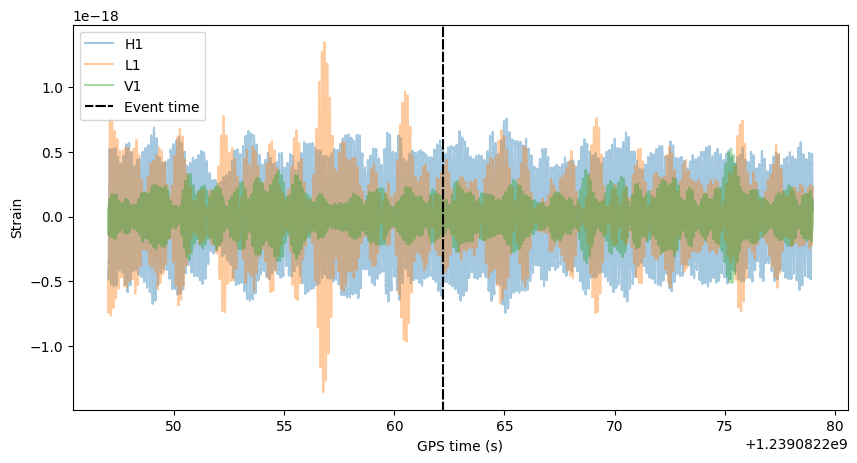

In [3]:
# Initialise figure (matplotlib)
fig = plt.figure(figsize=[10, 5])
ax = fig.gca()

# List the detectors we want to include
ifos = ['H1', 'L1', 'V1'] # hanford, livingston, virgo
for idx,ifo in enumerate(ifos):
    # Read in the data for each interferometer
    try:
        ts = merger.strain(ifo)
        ax.plot(ts.sample_times, ts, label=ifo, alpha=0.4, color=colors[idx])
    except:
        print(f"No {ifo} data available! Check if this is expected. "
              "Removing from our list.")
        ifos.remove(ifo)

ax.axvline(merger.time, color="black", linestyle=(1,(5,1)), label="Event time")
ax.set_ylabel('Strain')
ax.set_xlabel('GPS time (s)')
ax.legend(loc='upper left');

Note the scale of the y-axis. Gravitational wave signals observed by our observatories typically have peak strains of $\mathcal{O}(10^{-21})$ or less!

**In gravitational wave detector data signals are buried in noise.**

This is why we need to do some data conditioning/filtering to find and characterise them.

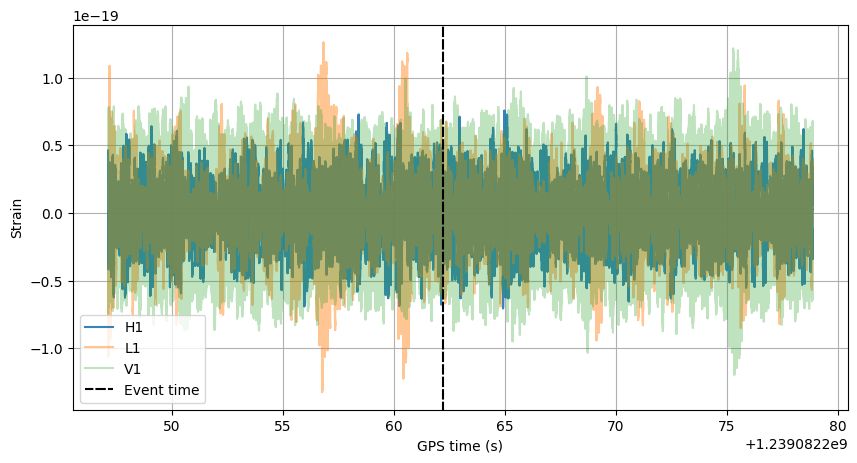

In [4]:
from pycbc import psd
import pycbc.filter as filter
# Set up dictionary for storing output
data = {}

# Initialise figure
fig = plt.figure(figsize=[10, 5])
ax = plt.gca()

# Define our low frequency cut off
f_low = 20.0 #livingston moet eigenlijk 30
for idx,ifo in enumerate(ifos):
    # Read in the data for each interferometer, this time using a finite impulse
    # response filter to remove high & low frequencies outside the signal range
    ts = merger.strain(ifo).highpass_fir(12, 512)
    data[ifo] = filter.resample_to_delta_t(ts, 1.0/2048)
    ax.plot(data[ifo].sample_times, data[ifo], label=ifo, alpha=0.9/(1+idx))

ax.axvline(merger.time, color="black", linestyle=(1,(5,1)), label="Event time")
ax.set_ylabel('Strain')
ax.set_xlabel('GPS time (s)')
ax.grid()
ax.legend()

As you can see, there is not much "signal" visible in the data. Let us take a look at the noise spectrum of the data

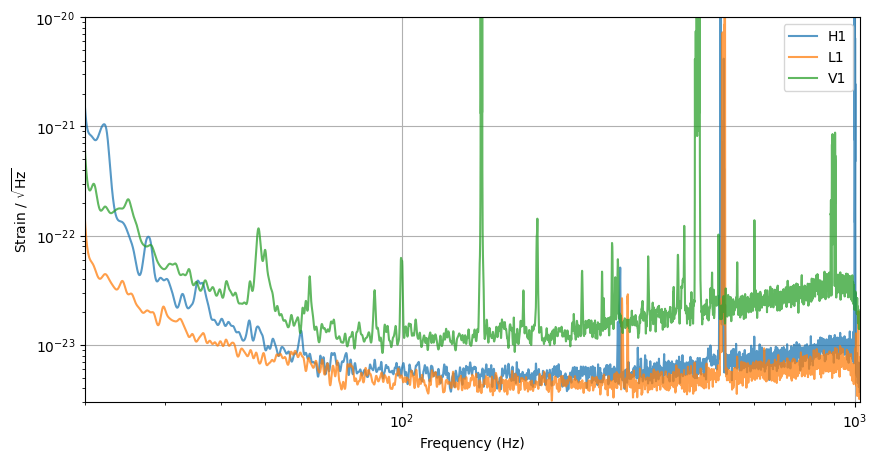

In [5]:
PSD = {}
ASD = {}
fig = plt.figure(figsize=[10, 5])
ax = plt.gca()

for ifo in ifos:
    # Estimate the power spectral density of the data
    # This chooses to use 2s samples in the PSD estimate.
    # One should note that the tradeoff in segment length is that
    # resolving narrow lines becomes more difficult.
    p = data[ifo].psd(2)
    p = psd.interpolate(p, data[ifo].delta_f)
    p = psd.inverse_spectrum_truncation(p, int(2 * data[ifo].sample_rate),
                                        low_frequency_cutoff=f_low)

    # The noise is often shown in terms of the amplitude spectral density, which
    # is the square root of the power spectral density
    PSD[ifo] = p
    ASD[ifo] = p**0.5

    ax.plot(ASD[ifo].sample_frequencies, ASD[ifo], label=ifo, alpha=0.75)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(3e-24, 1e-20)
ax.set_xlim(20, 1024)
ax.set_ylabel(r'Strain / $\sqrt{\mathrm{Hz}}$')
ax.set_xlabel('Frequency (Hz)')
ax.grid()
ax.legend()

We can see how the noise contribution is stronger at lower frequencies, which is primarily due to seismic noise and some thermal noise in the instrument itself.

At frequencies above a few hundred Hz the noise increases due to quantum shot noise.

You will notice that there are large spikes. These may be resonant frequencies of components in the interferometer, but also may be deliberately added for calibration purposes.

This is fine for our transient searches since, generally speaking, the thinner these lines are, the less of an impact they will have on our matched filtering analysis (they are more of a problem for finding continuous/stochastic signals).

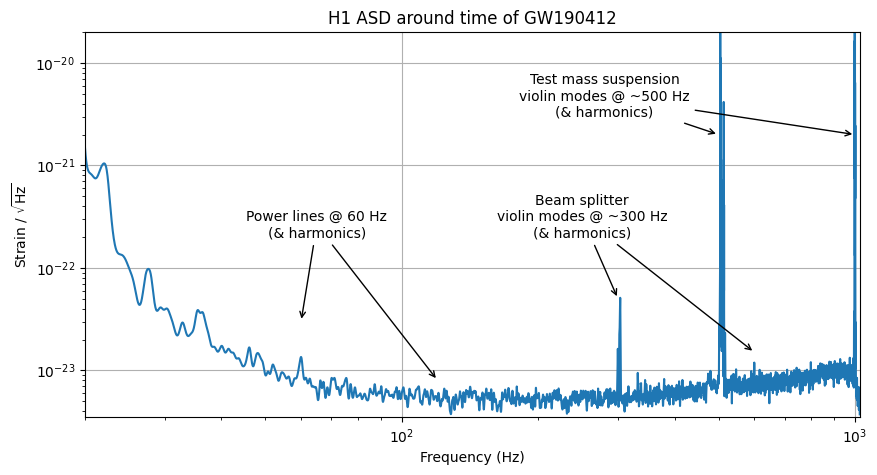

In [6]:
ifo = "H1"
arrowprops = {"arrowstyle": "->"}

fig = plt.figure(figsize=[10, 5])
ax = plt.gca()
ax.plot(ASD[ifo].sample_frequencies, ASD[ifo])

ax.annotate("Power lines @ 60 Hz\n(& harmonics)", (60, 3e-23), (65, 2e-22),
            ha="center", arrowprops=arrowprops)
ax.annotate("Power lines @ 60 Hz\n(& harmonics)", (120, 8e-24), (65, 2e-22),
            ha="center", arrowprops=arrowprops, alpha=0.0)

ax.annotate("Test mass suspension\nviolin modes @ ~500 Hz\n(& harmonics)", (500, 2e-21), (280, 3e-21),
            ha="center", arrowprops=arrowprops)
ax.annotate("Test mass suspension\nviolin modes @ ~500 Hz\n(& harmonics)", (1000, 2e-21), (280, 3e-21),
            ha="center", alpha=0.0, arrowprops=arrowprops)

ax.annotate("Beam splitter\nviolin modes @ ~300 Hz\n(& harmonics)", (300, 5e-23), (250, 2e-22),
            ha="center", arrowprops=arrowprops)
ax.annotate("Beam splitter\nviolin modes @ ~300 Hz\n(& harmonics)", (600, 1.5e-23), (250, 2e-22),
            ha="center", alpha=0.0, arrowprops=arrowprops)

ax.set_title("{} ASD around time of {}".format(ifo, merger.common_name))
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(3.5e-24, 2e-20)
ax.set_xlim(f_low, 1024)
ax.set_ylabel(r'Strain / $\sqrt{\mathrm{Hz}}$')
ax.set_xlabel('Frequency (Hz)')
ax.grid()

Now let's see what happens if we **whiten** the data. Whitening involves dividing by the noise PSD across the frequency range.

What will the data look like after this? Will it have nice properties, like Gaussianity?

Can we see the signal once we do this?

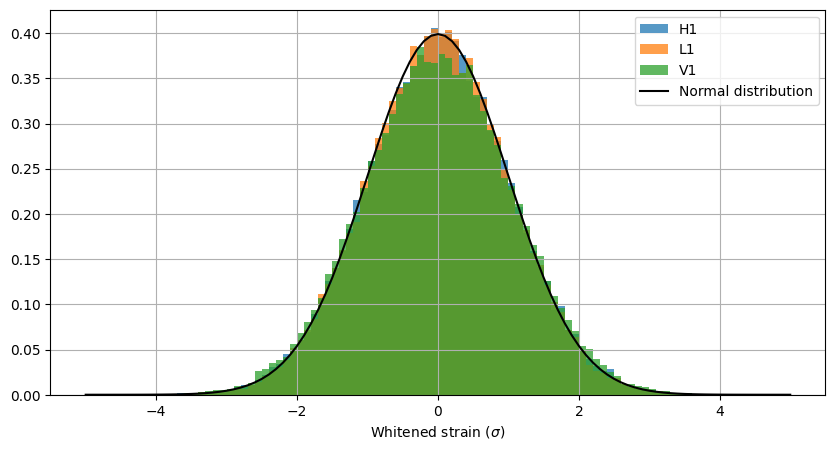

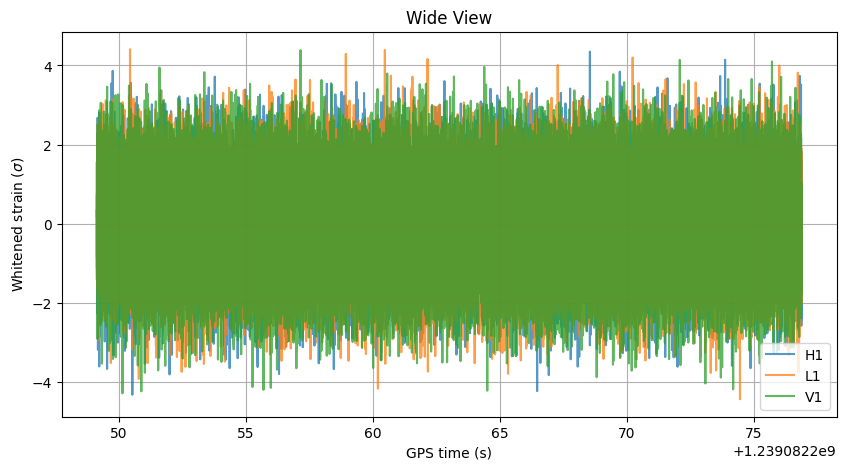

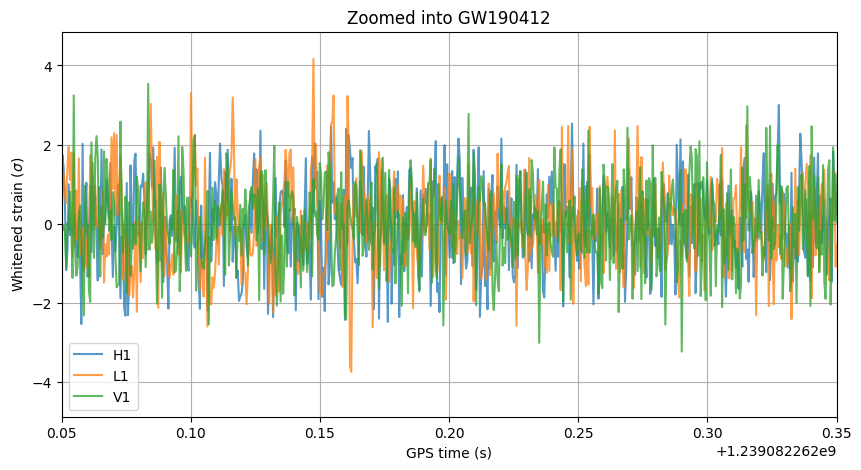

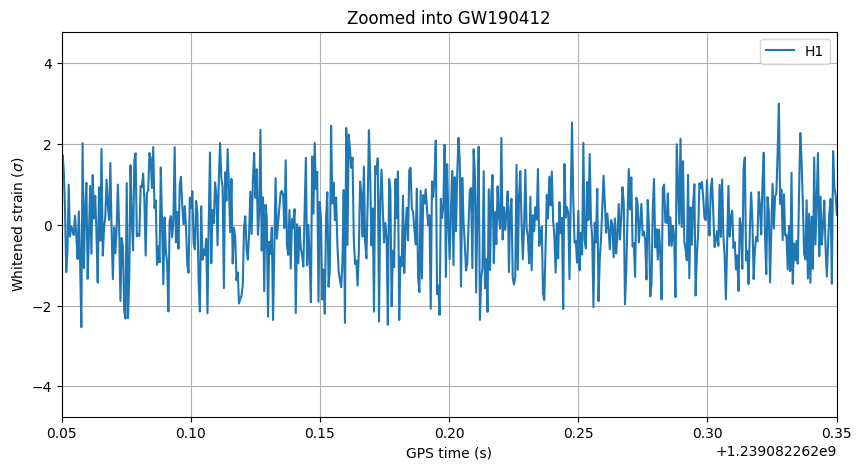

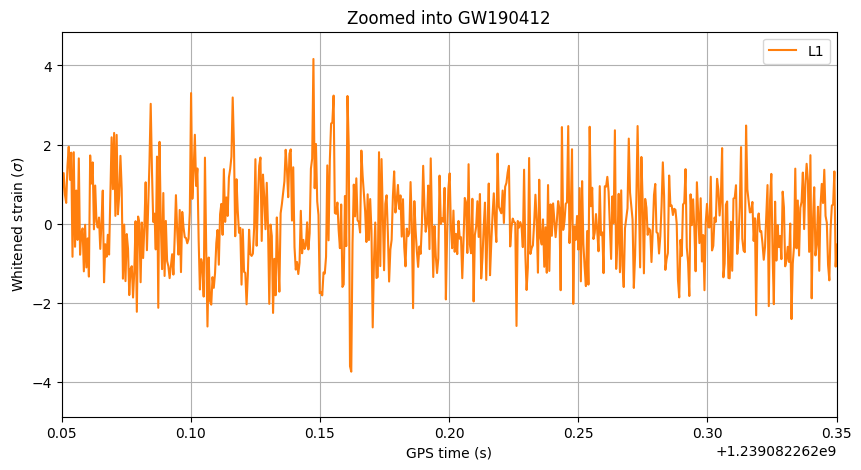

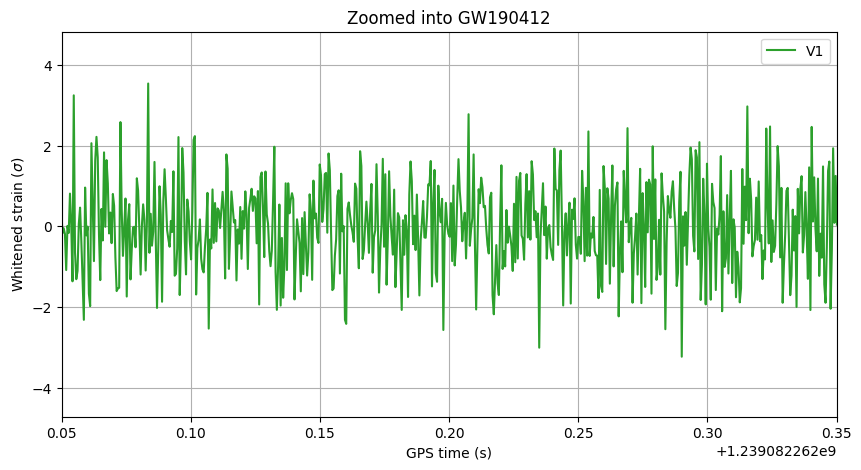

In [7]:
whitened = {}
colors = {}
for ifo in ifos:
    # Whiten by the PSD, including a normalisation of 1 / (2 * dt)
    norm = 1. / data[ifo].delta_t / 2.
    whitened_fs = data[ifo].to_frequencyseries() / (PSD[ifo] * norm)**0.5
    whitened[ifo] = whitened_fs.to_timeseries().crop(2,2)

# Are the whitened data Gaussian?
from scipy.stats import norm

fig = plt.figure(figsize=[10, 5])
ax = fig.gca()
bins = np.linspace(-5, 5, num=101)
for ifo in ifos:
    ax.hist(whitened[ifo], label=ifo, alpha=0.75, bins=bins, density=True)
ax.plot(bins, norm.pdf(bins), "k-", label="Normal distribution")
ax.legend()
ax.grid()
ax.set_xlabel(r"Whitened strain ($\sigma$)")
plt.show()
plt.close()

for w, title in [(None, "Wide View"), (.15, "Zoomed into {}".format(merger.common_name))]:
    fig = plt.figure(figsize=[10, 5])
    ax = fig.gca()
    for ifo in ifos:
        l = ax.plot(whitened[ifo].sample_times, whitened[ifo], label=ifo,
                    alpha=0.75)
        colors[ifo] = l[0].get_color()
        if w is not None:
            fig2 = plt.figure(figsize=[10, 5])
            ax2 = fig2.gca()
            ax2.plot(whitened[ifo].sample_times, whitened[ifo], label=ifo,
                     color=colors[ifo])
            ax2.legend()
            ax2.set_title(title)
            ax2.grid()
            ax2.set_xlim(merger.time - w, merger.time + w)
            ax2.set_ylabel(r"Whitened strain ($\sigma$)")
            ax2.set_xlabel('GPS time (s)')
            fig2.show()
    ax.legend()
    ax.set_title(title)
    ax.grid()
    if w is not None:
        ax.set_xlim(merger.time - w, merger.time + w)
    ax.set_ylabel(r"Whitened strain ($\sigma$)")
    ax.set_xlabel('GPS time (s)')

There is a period of some excited strain around 0.35–0.45 on the zoomed in plot for H1 and L1 that looks like it has some correlated oscillatory pattern to it.

We might actually be able to do a bit better here by getting rid of the high frequency end of the noise with a lowpass filter (as we will see, our signal is very low frequency, so we won't be throwing away signal).

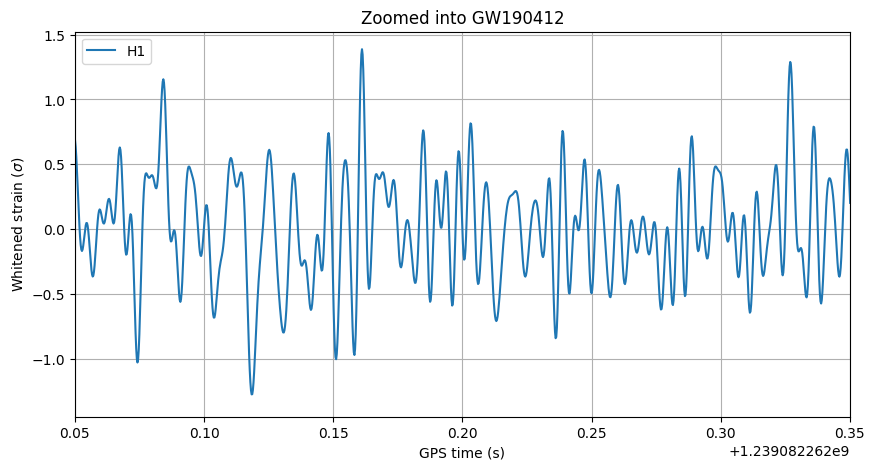

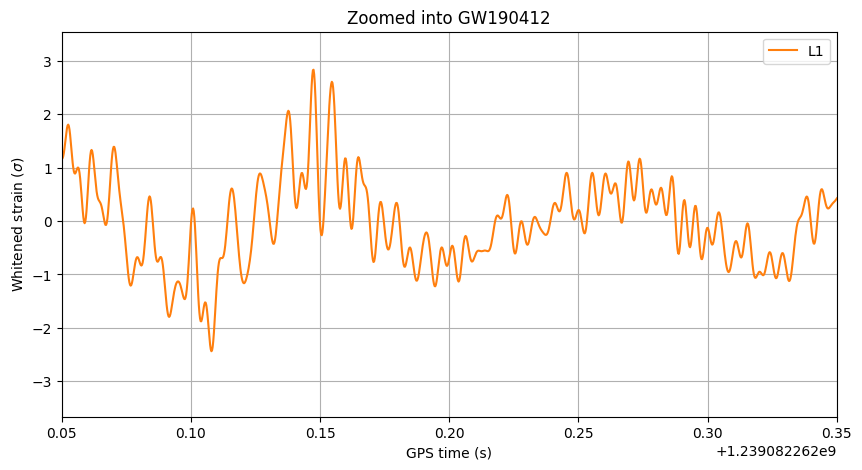

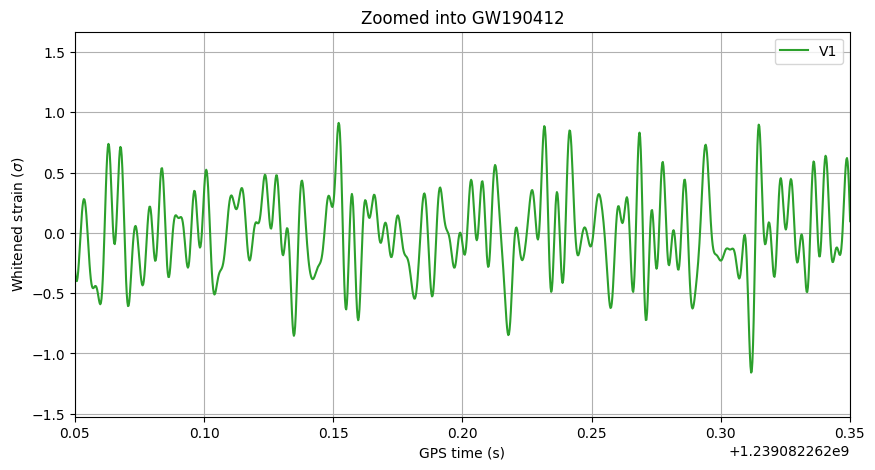

In [8]:
bpassed = {}
for ifo in ifos:
    # Put all the steps above together, adding a lowpass filter
    ts = merger.strain(ifo)
    # Estimate PSD
    p = ts.psd(2)
    p = psd.interpolate(p, ts.delta_f)
    p = psd.inverse_spectrum_truncation(p, int(2 * ts.sample_rate),
                                        low_frequency_cutoff=f_low)
    # Whiten
    norm = 1. / ts.delta_t / 2.
    wh = (ts.to_frequencyseries() / (p * norm)**0.5).to_timeseries().crop(2,2)

    # Highpass and lowpass
    bpassed[ifo] = wh.highpass_fir(12,512).lowpass_fir(250,512)

    fig = plt.figure(figsize=[10, 5])
    ax = fig.gca()
    ax.plot(bpassed[ifo].sample_times, bpassed[ifo], label=ifo, color=colors[ifo])
    ax.legend()
    ax.set_title(title)
    ax.grid()
    ax.set_xlim(merger.time - 0.15, merger.time + 0.15)
    ax.set_ylabel(r"Whitened strain ($\sigma$)")
    ax.set_xlabel('GPS time (s)')

---

### 2. Matched filtering with model templates

We are now ready to carry out **matched filtering** of the data to see if we can find a signal contained in there. This will generate a signal-to-noise (SNR) time series. Spikes will indicate times when the template has a better than average match.

However, as we will see, gravitational wave signals are not the only things that can lead to spikes in SNR. **Non-Gaussian noise fluctuations, often referred to as "glitches", can also create these spikes.**
However, we can employ further processing to **try** to reject noise in favour of signals.

Let's now **generate a template waveform using parameters that we know are reasonably representative of the signal** and use that template to filter the data. *This will be a rough but quick approach.*

To begin with, we must remember that the event's listed parameters are in the **source** frame, i.e. represent the physical parameters of the system.
*But we observe a gravitational wave signal here on Earth. That means the signal may appear redshifted in the frame of our detectors due to cosmological expansion, as often happens in other fields within astronomy, so we need to account for this.*

Redshift is 0.15. Therefore 30.1 -> 34.615 and 8.3 -> 9.545


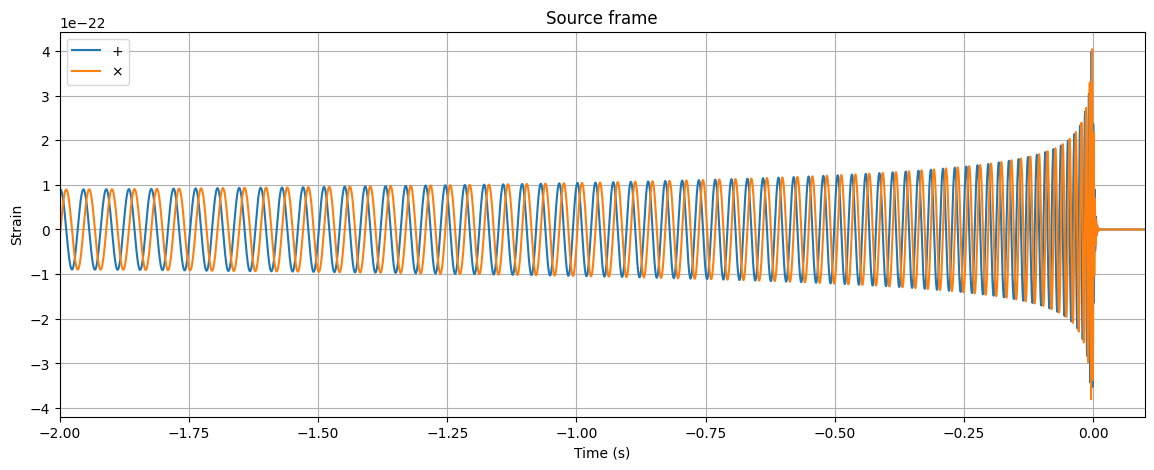

Text(0, 0.5, 'Strain')

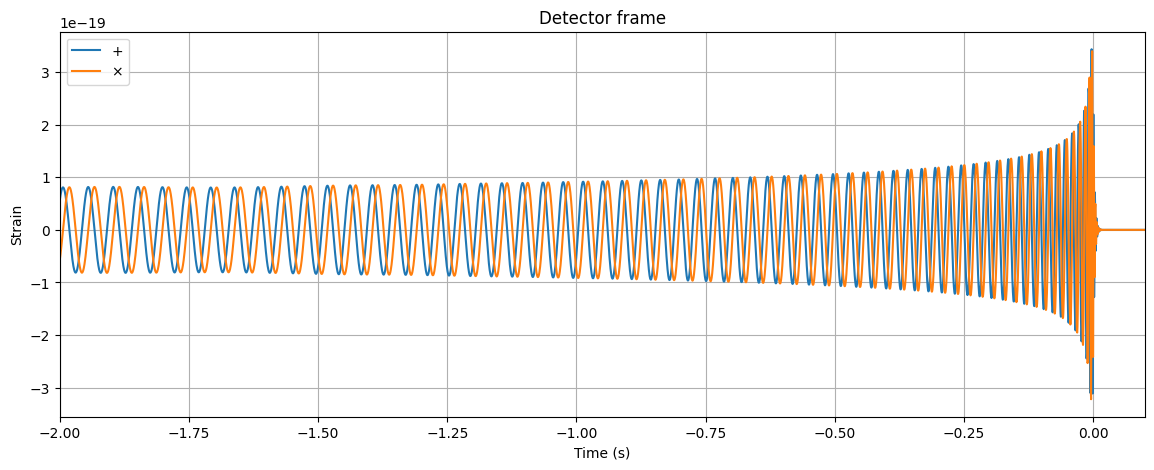

In [9]:
from pycbc import waveform as wf, conversions as conv

# Calculate the component mass of each black hole in the detector frame
m1_det = merger.mass1 * (1 + merger.z)
m2_det = merger.mass2 * (1 + merger.z)
print("Redshift is {}. Therefore {} -> {} and {} -> {}".format(merger.z, merger.mass1, m1_det, merger.mass2, m2_det))

# Generate signals in the time domain and see the redshift effect
# First the *source* frame
# Plus and Cross polarisations in the source frame
hp_src, hc_src = wf.get_td_waveform(approximant="IMRPhenomD",
                                    mass1=merger.mass1, mass2=merger.mass2, distance=merger.distance,
                                    f_lower=f_low, delta_t=data[ifo].delta_t)

fig = plt.figure(figsize=[14, 5])
ax = plt.gca()
ax.plot(hp_src.sample_times, hp_src, label=r"$+$");
ax.plot(hc_src.sample_times, hc_src, label=r"$\times$");
ax.legend()
ax.set_title("Source frame")
ax.grid()
ax.set_xlim(-2, 0.1)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Strain')
plt.show()
plt.close()

# Now in the *detector* (Earth) frame
hp_det, hc_det = wf.get_td_waveform(approximant="IMRPhenomD",
                                    mass1=m1_det, mass2=m2_det,
                                    f_lower=f_low, delta_t=data[ifo].delta_t)

fig = plt.figure(figsize=[14, 5])
ax = plt.gca()
ax.plot(hp_det.sample_times, hp_det, label=r"$+$");
ax.plot(hc_det.sample_times, hc_det, label=r"$\times$");
ax.legend()
ax.set_title("Detector frame")
ax.grid()
ax.set_xlim(-2, 0.1)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Strain')

We can see here how the cosmological redshift effect stretches the signal out to lower frequencies. Clearly, for a source at this distance, if we didn't account for this redshift our analysis would be severely affected.

Better technology -> better detector sensitivities -> farther probes -> more sensitive to the frame of reference.

We can now use the detector frame masses to generate a ***frequency domain*** waveform and use that to filter the data.
This is ideally the fourier transform of our time domain signal within the detectors frequency band.

(20, 1024)

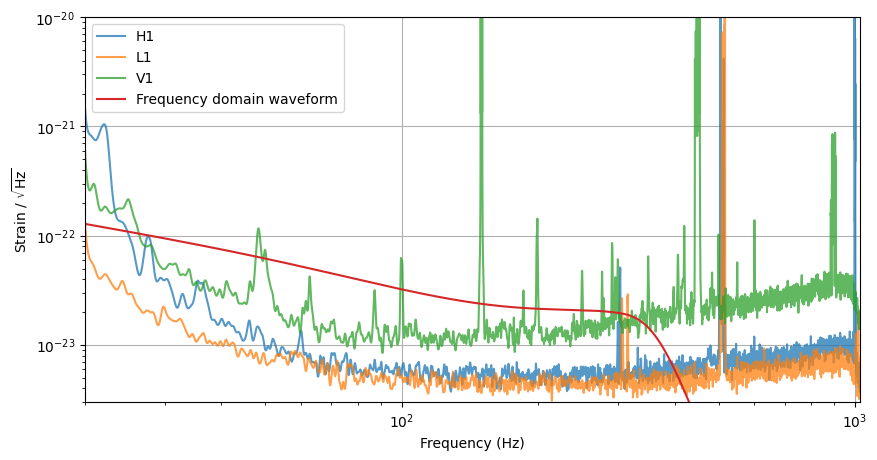

In [10]:
# This is a frequency domain waveform generator. It has a very similar syntax to the time domain
# waveform function used above. This function returns both a plus and a cross
# polarization waveform, but we will just use the plus polarization in building our template
# as these are only different by a phase offset in this specific case.
hp, hc = wf.get_fd_waveform(approximant="IMRPhenomD",
                            mass1=m1_det, mass2=m2_det, distance=merger.distance,
                            f_lower=f_low, delta_f=data[ifo].delta_f)


# Plot this frequency domain waveform and compare to the noise in our detectors
fig = plt.figure(figsize=[10, 5])
ax = plt.gca()
for ifo in ifos:
    # Plot each detector's ASD
    ax.plot(ASD[ifo].sample_frequencies, ASD[ifo], label=ifo, alpha=0.75)
# Plot the waveform. We must scale by the sqrt(Hz) factor to make the comparison
ax.plot(hp.sample_frequencies, abs(hp) * np.sqrt(hp.sample_frequencies),
        label="Frequency domain waveform")
ax.grid()
ax.legend()
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel(r'Strain / $\sqrt{\mathrm{Hz}}$')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(3e-24, 1e-20)
ax.set_xlim(20, 1024)

The signal appears above the noise level in both interferometers but to differing degrees.

Note how the merger happens at ~200 Hz although we have sensitivities ranging through to ~1024 Hz! This emphasises that LIGO and Virgo will struggle to observe merger events that are sufficiently MASSIVE!

Based on this plot – and ignoring a number of caveats (e.g. each detector will have a different fractional sensitivity/response in the direction of the signal source) – we might expect this signal to have slightly different signal-to-noise ratios in both H1 and L1 detectors with a higher SNR in L1. However, SNR in V1 seems to be much lower.

Let's see if this is correct by using the template to filter the data properly.

Text(0, 0.5, 'Signal-to-noise (SNR)')

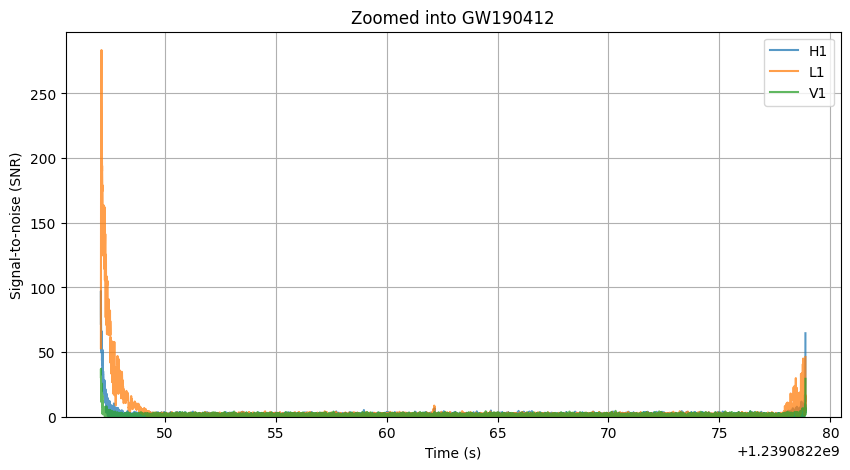

In [11]:
# For each observatory use this template to calculate the SNR time series
# Resize the array so it matches the length of the PSD arrays
hp.resize(len(PSD[ifo]))

fig = plt.figure(figsize=[10, 5])
ax = plt.gca()

snr_full = {}
for ifo in ifos:
    # Do matched filter, filtering data that has noise given by PSD with
    # template hp. We also pass a low frequency argument.
    snr_full[ifo] = filter.matched_filter(hp, data[ifo], psd=PSD[ifo],
                                        low_frequency_cutoff=f_low)
    ax.plot(snr_full[ifo].sample_times, abs(snr_full[ifo]), label=ifo,
            alpha=0.75)

ax.legend()
ax.set_title(title)
ax.grid()
ax.set_ylim(0, None)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Signal-to-noise (SNR)')

This first thing you might notice is the large spikes at either end.

These are the result of filtering non-cyclical data; the algorithm treats the data like it is a ring, with the first and last data points connected. Since they are not actually related this will **not be a smooth boundary**, and the template will "ring" off on this discontinuity. We should ignore these corrupted times, so we will cut them off and replot, zooming in to the smaller spike we can see near the middle.

Hence, if there is an estimate of the duration of a signal, we would choose a slightly longer signal (at both ends) for filtering.

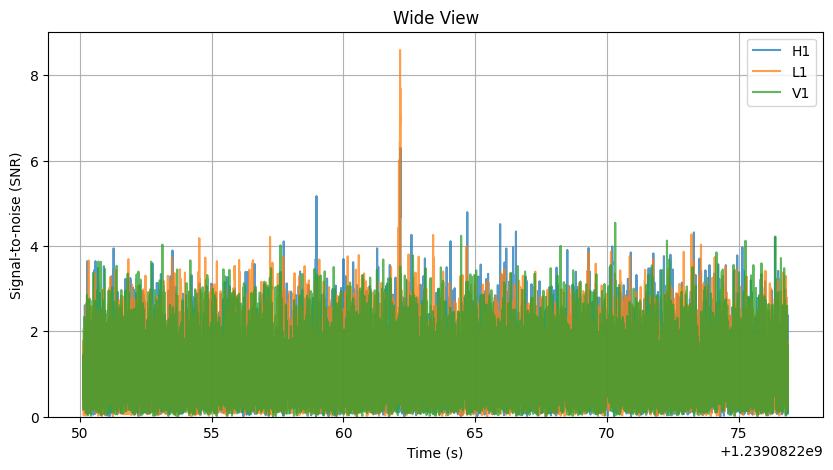

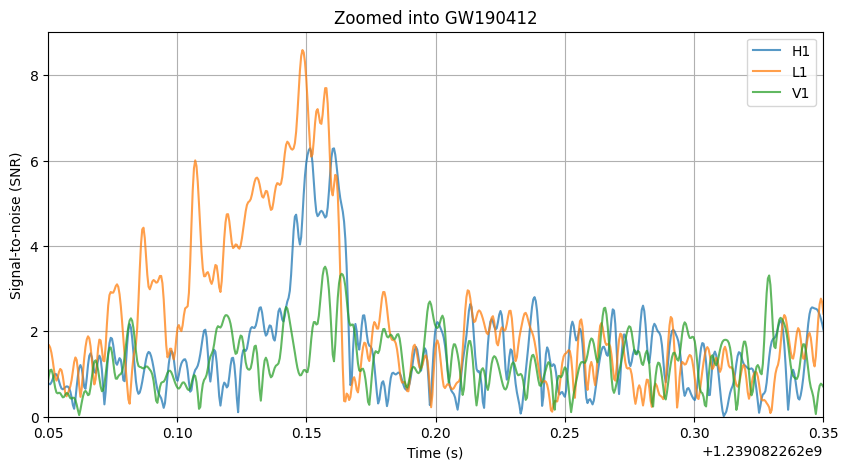

Maximum SNR in H1 =  6.29 at 1239082262.1514
Maximum SNR in L1 =  8.59 at 1239082262.1484
Maximum SNR in V1 =  3.51 at 1239082262.1572


In [12]:
snr = {}
peak = {}
# Crop out the corrupted time at either end
for ifo in ifos:
  snr[ifo] = snr_full[ifo].crop(3, 2)

# Show a couple of sizes
for w, title in [(None, "Wide View"), (.15, "Zoomed into {}".format(merger.common_name))]:
    fig = plt.figure(figsize=[10, 5])
    ax = plt.gca()
    for ifo in ifos:
        ax.plot(snr[ifo].sample_times, abs(snr[ifo]), label=ifo,
                alpha=0.75)

    ax.legend()
    ax.set_title(title)
    ax.grid()
    if w is not None:
      ax.set_xlim(merger.time - w, merger.time + w)
    ax.set_ylim(0, None)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Signal-to-noise (SNR)')
    plt.show()
    plt.close()

# Find the local peaks
for ifo in ifos:
    sliced = snr[ifo].time_slice(merger.time - w, merger.time + w)
    pk, pidx = sliced.abs_max_loc()
    peak[ifo] = sliced.sample_times[pidx]

    print("Maximum SNR in {} = {:5.2f} at {:.4f}".format(ifo, pk, peak[ifo]))

There is quite a prominent spike in SNR in H1 and L1! H1 sees the largest SNR peak.

In practice, we do not stop our analyses with SNR. An SNR spike may be due to something that does not actually resemble our template very closely. **We can test for this with a $\chi^2$-based signal consistency test**. We employ a version of the test described [in this paper](https://arxiv.org/pdf/gr-qc/0405045.pdf). Schematically, we chop up our template into $p$ number of bins, chosen such that each should contain an equal amount of signal power. We then see how much each bin really contributes to the SNR ($\rho_i$). We can then calculate our statistic as the difference between the SNR in one bin, and the expected fraction of the total SNR ($\rho$).

$
\chi^2 = \sum^p_{i=0} (\rho_i - \rho / p)^2
$

This will have $2p−2$ degrees of freedom as each SNR is ***complex***, representing both possible orthogonal phases the signal could have contributions from. We will normalize this statistic by dividing by the number of degrees of freedom, producing a reduced $\chi^2_r$.

We expect that this statistic will be high when the template does not match the data well, and near unity when the data either is Gaussian noise, or it contains the expected signal in addition to Gaussian noise.

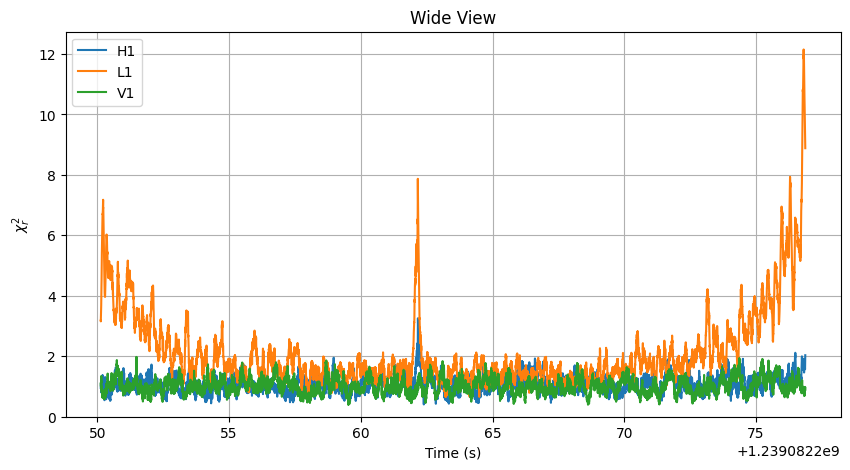

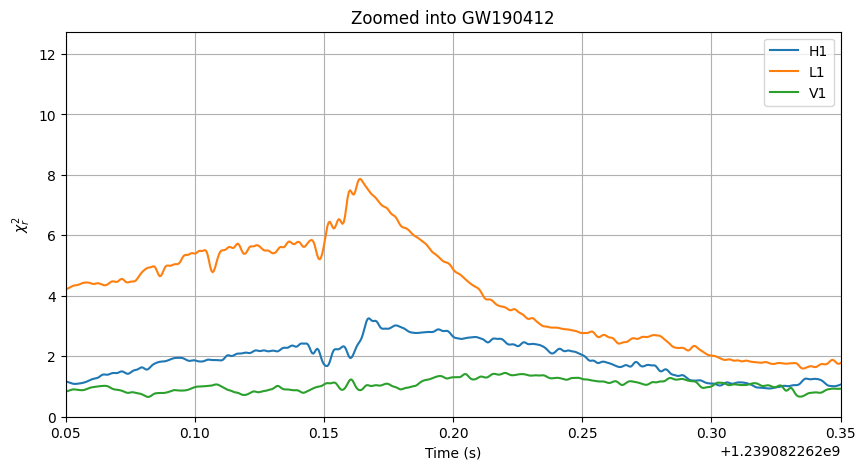

In [22]:
from pycbc.vetoes import power_chisq

chisq = {}
for ifo in ifos:
    # The number of bins to use. In principle, this choice is arbitrary. In practice,
    # this is empirically tuned.
    nbins = 20
    chisq[ifo] = power_chisq(hp, data[ifo], nbins, PSD[ifo], low_frequency_cutoff=f_low)
    chisq[ifo] = chisq[ifo].crop(3, 2)

    # Scale by the number of degrees of freedom
    dof = nbins * 2 - 2
    chisq[ifo] /= dof

# Show a couple of sizes
for w, title in [(None, "Wide View"), (.15, "Zoomed into {}".format(merger.common_name))]:
    fig = plt.figure(figsize=[10, 5])
    ax = plt.gca()
    for ifo in ifos:
        ax.plot(chisq[ifo].sample_times, chisq[ifo], label=ifo)

    ax.legend()
    ax.set_title(title)
    ax.grid()
    if w is not None:
      ax.set_xlim(merger.time - w, merger.time + w)
    ax.set_ylim(0, None)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel(r'$\chi^2_r$')

We can then use the reduced $\chi^2_r$ statistic to produce a detection statistic $\rho_{\mathrm{det}}$ that re-weights the matched-filter SNR $\rho$.

$
\rho_{\mathrm{det}} = \frac{\rho}{\left(\frac{1}{2}\left[1 + \left(\chi^2_r\right)^{\frac{q}{n}}\right]\right)^{\frac{1}{q}}}
$

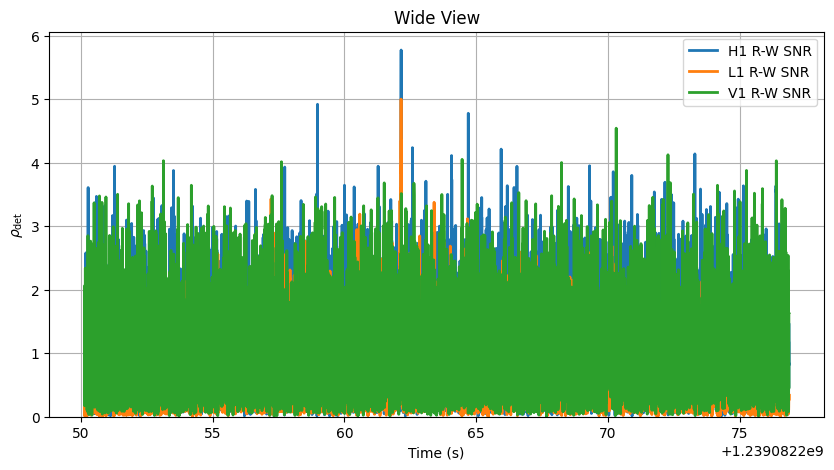

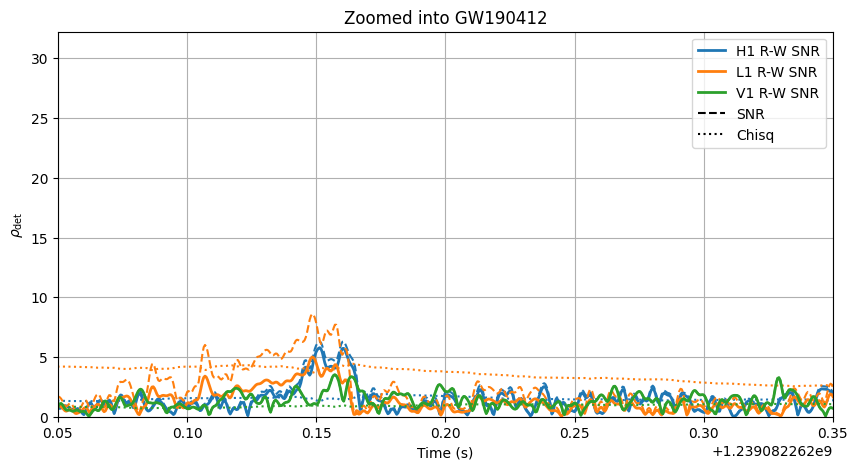

In [21]:
from pycbc.events.ranking import newsnr

# The re-weighted SNR statistic is sometimes known as "New SNR"
nsnr = {ifo:newsnr(abs(snr[ifo]), chisq[ifo]) for ifo in ifos}
peak_time = {}

# Show a couple of plots (zoomed, unzoomed)
for w, title in [(None, "Wide View"), (.15, "Zoomed into {}".format(merger.common_name))]:
    fig = plt.figure(figsize=[10, 5])
    ax = plt.gca()
    for ifo in ifos:
        l = ax.plot(snr[ifo].sample_times, nsnr[ifo], linewidth=2,
                    label="{} R-W SNR".format(ifo))
        if w is not None:
            ax.plot(snr[ifo].sample_times, abs(snr[ifo]), "--", color=l[0].get_color())
            ax.plot(chisq[ifo].sample_times, chisq[ifo], ":", color=l[0].get_color())
    if w is not None:
        ax.set_xlim(merger.time - w, merger.time + w)
        handles, labels = ax.get_legend_handles_labels()
        snr_line = plt.Line2D([], [], color='black', linestyle="--", label="SNR")
        chisq_line = plt.Line2D([], [], color='black', linestyle=":", label="Chisq")
        ax.legend(handles=handles+[snr_line, chisq_line])
    else:
        ax.legend()
    ax.set_title(title)
    ax.grid()
    ax.set_ylim(0, None)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel(r'$\rho_{\mathrm{det}}$')
    plt.show()
    plt.close()

for ifo in ifos:
    peak = abs(nsnr[ifo]).argmax()
    peak_time[ifo] = snr[ifo].sample_times[peak]

What we see here is that, in L1 data, there is not very many times when the $\chi^2$ test down-weights the triggers, it is a bit more apparent in H1 data.

We already saw that the whitened data for L1 was closer to Gaussian distributed as compared to H1, so this is not very surprising.

---